In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo


This notebook is meant to help be explicit about the background "magic" that Nengo is using to create the connection weights for the networks.  In particular, I want to show how to get access to those weights and how to build networks yourself manually so there's no magic anywhere (and you could just take those weights and go use them in some other neural network simulator).

## A Single Ensemble

We start with just one single Ensemble that's computing the identity function (i.e. the output should be the same as the input).  Here it is in Nengo:

In [11]:
ens_seed = 5
stim_seed = 6

model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, seed=ens_seed)
    output = nengo.Node(None, size_in=1)
    nengo.Connection(stim, ens)
    conn = nengo.Connection(ens, output)
    p_stim = nengo.Probe(stim)
    p_neurons = nengo.Probe(ens.neurons)
    p_output = nengo.Probe(output)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

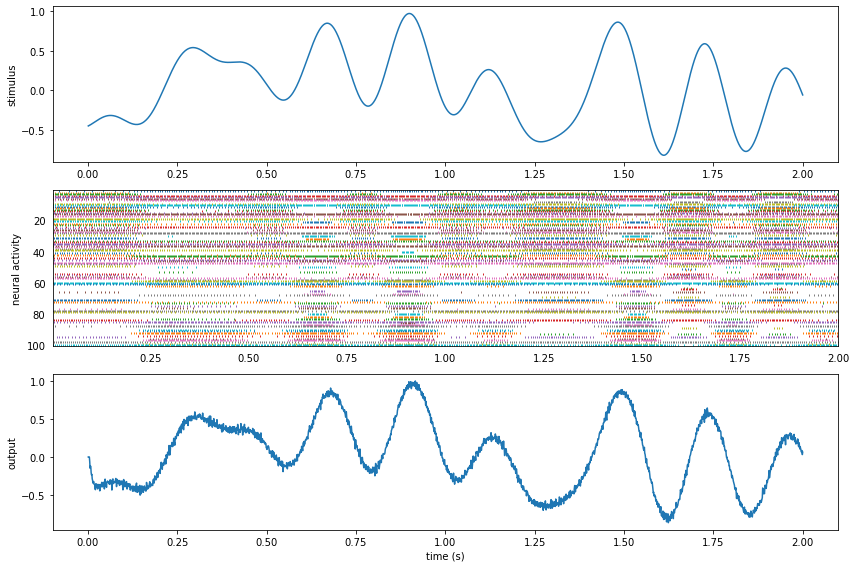

In [3]:
plt.figure(figsize=(12,8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(3, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons])
plt.ylabel('neural activity')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_output])
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()


So, nengo went ahead an randomly generated encoders (the input weights to the neurons) and solved for the decoders (the output weights from the neurons) that best approximate the identity function.  Here's how we can get those weights:

In [4]:
E = sim.data[ens].encoders
D = sim.data[conn].weights

Now let's try making a network ourselves using those weights.

In [5]:
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, seed=ens_seed)
    output = nengo.Node(None, size_in=1)
    nengo.Connection(stim, ens.neurons, transform=E)    # input weights
    nengo.Connection(ens.neurons, output, transform=D)  # output weights
    p_stim = nengo.Probe(stim)
    p_neurons = nengo.Probe(ens.neurons)
    p_output = nengo.Probe(output)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

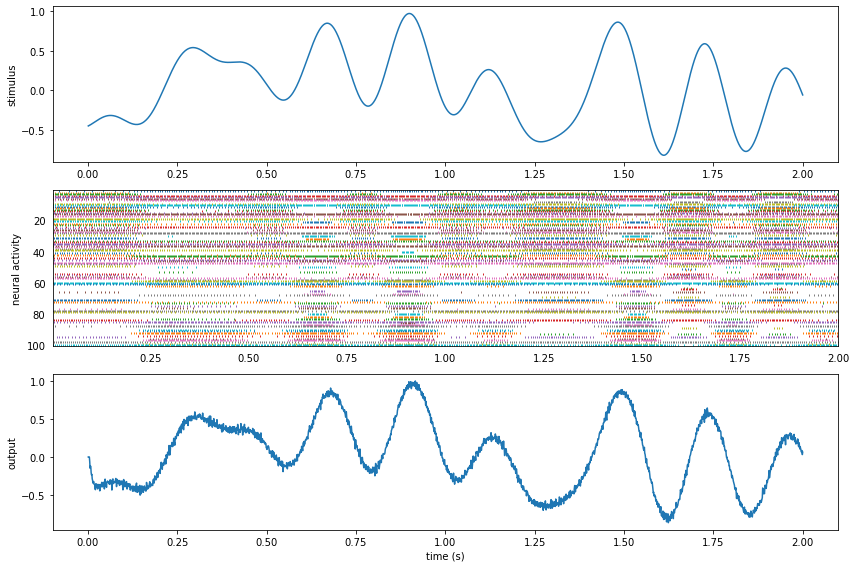

In [6]:
plt.figure(figsize=(12,8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(3, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons])
plt.ylabel('neural activity')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_output])
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()


Those should be perfectly identical graphs.  However, you will notice that I'm still setting a random number seed on the `Ensemble`.  The reason I'm doing that is that, by default, neurons in nengo also get a random gain and bias, so that they exhibit some heterogeneity.  We can grab that information as well, and then we can include that in our network.  That way we can have the exact same system work even when the underlying neurons are identical (that is, we manually implement the bias connection and we multiply our input weights by the gain so it should have the same effect).

In [7]:
gain = sim.data[ens].gain
bias = sim.data[ens].bias

In [8]:
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))
    
    bias_stim = nengo.Node(1)
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, gain=np.ones(100), bias=np.zeros(100))
    output = nengo.Node(None, size_in=1)
    nengo.Connection(stim, ens.neurons, transform=(gain*E.T).T)   # input weights (including gain)
    nengo.Connection(bias_stim, ens.neurons, transform=bias.reshape((100, 1)), synapse=None)  # bias
    nengo.Connection(ens.neurons, output, transform=D)            # output weights
    p_stim = nengo.Probe(stim)
    p_neurons = nengo.Probe(ens.neurons)
    p_output = nengo.Probe(output)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)

c:\users\terry\documents\github\nengo\nengo\neurons.py:438: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

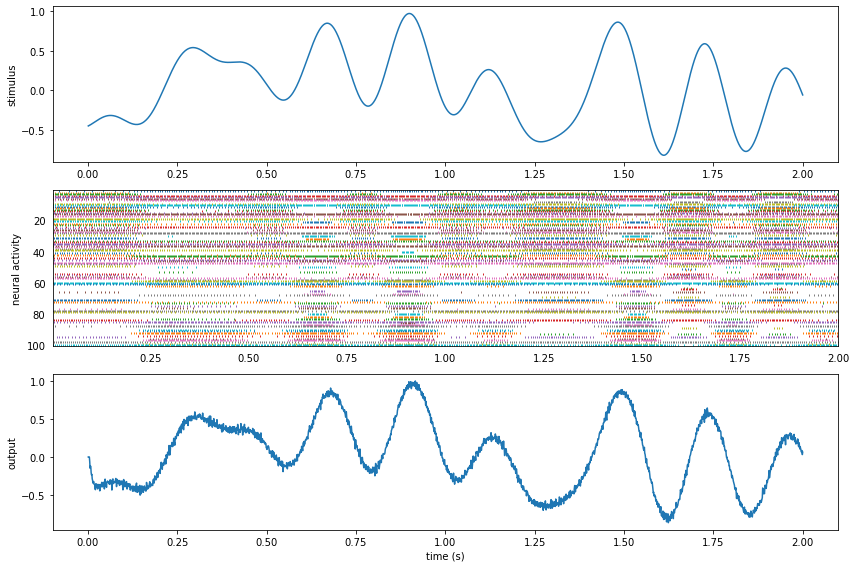

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(3, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons])
plt.ylabel('neural activity')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_output])
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()


## Connecting Two Ensembles

Now let's see what happens when we connect one Ensemble to another.  For this case, we'll compute a function $f(x)=x^2$ in this connection between the Ensembles.  The main trick is we're just going to multiply the decoder weights by the encoder weights to get the full weight matrix that will act the same as having the separate matrices. 

It should be noted that on most hardware, it is more efficient to keep these matrices separated, but when comparing to biology you want to combine the matrices, since that's the way to get actual connection weights.

In [12]:
ens1_seed = 5
ens2_seed = 7
stim_seed = 6

model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))
    ens1 = nengo.Ensemble(n_neurons=100, dimensions=1, seed=ens1_seed)
    ens2 = nengo.Ensemble(n_neurons=90, dimensions=1, seed=ens2_seed)
    output = nengo.Node(None, size_in=1)
    nengo.Connection(stim, ens1)
    conn1 = nengo.Connection(ens1, ens2, function=lambda x: x**2)
    conn2 = nengo.Connection(ens2, output)
    p_stim = nengo.Probe(stim)
    p_neurons1 = nengo.Probe(ens1.neurons)
    p_neurons2 = nengo.Probe(ens2.neurons)
    p_output = nengo.Probe(output)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

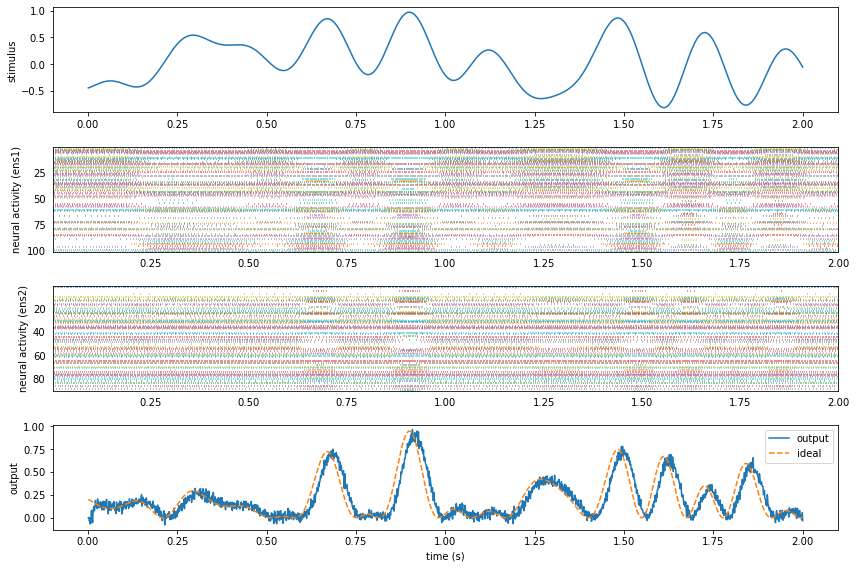

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(4, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(4, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons1])
plt.ylabel('neural activity (ens1)')
plt.subplot(4, 1, 3)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons2])
plt.ylabel('neural activity (ens2)')
plt.subplot(4, 1, 4)
plt.plot(sim.trange(), sim.data[p_output], label='output')
plt.plot(sim.trange(), sim.data[p_stim]**2, ls='--', label='ideal')
plt.legend()
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()


First, let's grab all the matrices that nengo generated.

In [15]:
E1 = sim.data[ens1].encoders
D1 = sim.data[conn1].weights
E2 = sim.data[ens2].encoders
D2 = sim.data[conn2].weights
gain1 = sim.data[ens1].gain
bias1 = sim.data[ens1].bias
gain2 = sim.data[ens2].gain
bias2 = sim.data[ens2].bias

# we always want to use gain and encoders together, so let's combine them 
E1 = (gain1*E1.T).T   
E2 = (gain2*E2.T).T

Now we build our model using those weights

In [16]:
model2 = nengo.Network()
with model2:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))    
    bias_stim = nengo.Node(1)
    
    ens1 = nengo.Ensemble(n_neurons=100, dimensions=1, gain=np.ones(100), bias=np.zeros(100))
    ens2 = nengo.Ensemble(n_neurons=90, dimensions=1, gain=np.ones(90), bias=np.zeros(90))
    output = nengo.Node(None, size_in=1)
    
    nengo.Connection(stim, ens1.neurons, transform=E1)
    nengo.Connection(bias_stim, ens1.neurons, transform=bias1.reshape((100, 1)), synapse=None)
    nengo.Connection(bias_stim, ens2.neurons, transform=bias2.reshape((90, 1)), synapse=None)
    nengo.Connection(ens2.neurons, output, transform=D2)
    
    W = E2.dot(D1)
    nengo.Connection(ens1.neurons, ens2.neurons, transform=W)
    
    p_stim = nengo.Probe(stim)
    p_neurons1 = nengo.Probe(ens1.neurons)
    p_neurons2 = nengo.Probe(ens2.neurons)
    p_output = nengo.Probe(output)
    
sim2 = nengo.Simulator(model2)
with sim:
    sim2.run(2)

c:\users\terry\documents\github\nengo\nengo\neurons.py:438: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

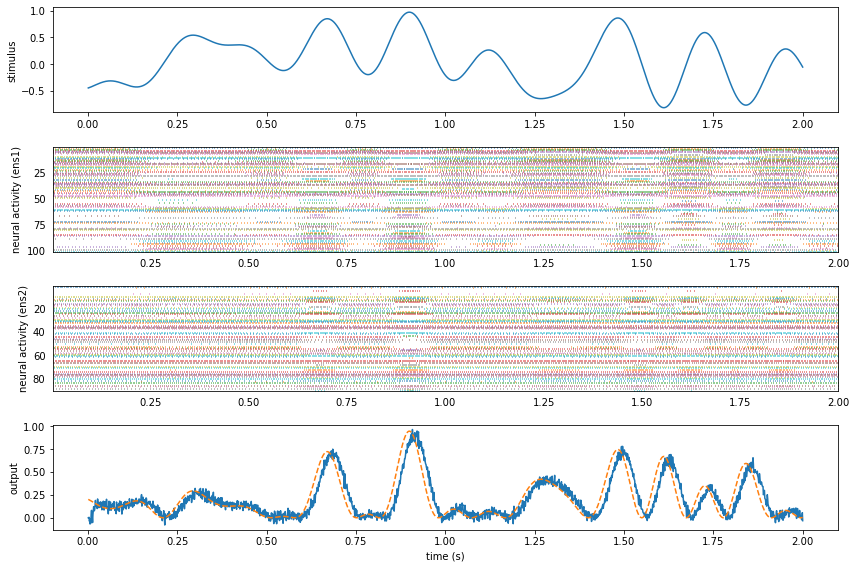

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(4, 1, 1)
plt.plot(sim2.trange(), sim2.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(4, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim2.trange(), sim2.data[p_neurons1])
plt.ylabel('neural activity (ens1)')
plt.subplot(4, 1, 3)
nengo.utils.matplotlib.rasterplot(sim2.trange(), sim2.data[p_neurons2])
plt.ylabel('neural activity (ens2)')
plt.subplot(4, 1, 4)
plt.plot(sim2.trange(), sim2.data[p_output])
plt.plot(sim2.trange(), sim2.data[p_stim]**2, ls='--')
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()


Success!

## Recurrent Connections

To implement recurrent connections, we do exactly the same thing as for the feed-forward connections.   

The example we'll do here is to implement an LMU where we use spiking neurons to compute the optimal differential equation for storing information over a window in time.  Here's code to generate that differential equation.  It also has code for computing what would be the weights to use to extract out information from any particular point in time, so we'll use that to make a system that remembers data over the last 250ms and outputs what it thinks the input was 250ms ago.

In [18]:
import scipy.linalg
from scipy.special import legendre

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
        self.A = A / theta
        self.B = B / theta        
        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

    def get_weights_for_delays(self, r):
        # compute the weights needed to extract the value at time r
        # from the network (r=0 is right now, r=1 is theta seconds ago)
        r = np.asarray(r)
        m = np.asarray([legendre(i)(2*r - 1) for i in range(self.q)])
        return m.reshape(self.q, -1).T

Here is our implementation in normal Nengo terms.  Notice that for the Connections I'm using `transform=tau*ldn.B` and `transform=tau*ldn.A+np.eye(ldn.q)`.  I could have written that as `function=lambda x: (tau*ldn.B).dot(x)` and `function=lambda x: (tau*ldn.A+np.eye(ldn.q)).dot(x)` instead, and gotten exactly the same result.  If I specify the function, then it computes a decoder for exactly that function.  If I specify a transform only, then it computes a decoder for the identity function and then multiplies that resulting decoder weights by the transform.  This should be the identical result.  However, by doing it separately like this, I can do less calculation.  In particular, since there are two Connections coming out of the ensemble (one going to `output` and one going back to itself), I only have to compute the identity function decoder once, and it just gets multiplied by different things in different cases.

In [19]:
ens_seed = 5
stim_seed = 6
ldn = LDN(theta=0.25, q=6)
tau = 0.1

model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))
    ens = nengo.Ensemble(n_neurons=1000, dimensions=ldn.q, seed=ens_seed)
    nengo.Connection(stim, ens, transform=tau*ldn.B, synapse=tau)
    nengo.Connection(ens, ens, transform=tau*ldn.A+np.eye(ldn.q), synapse=tau)
    
    output = nengo.Node(None, size_in=1)
    nengo.Connection(ens, output, transform=ldn.get_weights_for_delays(1))
    
    p_stim = nengo.Probe(stim)
    p_neurons = nengo.Probe(ens.neurons)
    p_output = nengo.Probe(output, synapse=0.01)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

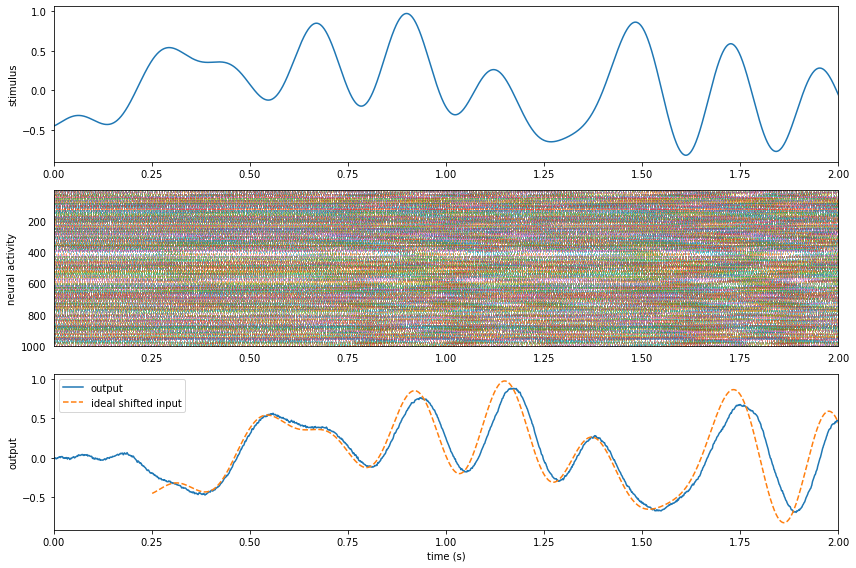

In [21]:
plt.figure(figsize=(12,8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.xlim(0, 2)
plt.ylabel('stimulus')
plt.subplot(3, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons])
plt.ylabel('neural activity')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_output], label='output')
plt.plot(sim.trange()+ldn.theta, sim.data[p_stim], ls='--', label='ideal shifted input')
plt.legend()
plt.xlim(0, 2)
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()

That seems to work and gives an output that tracks the ideal input from 250ms previously.

Now let's implement it ourselves manually.

First, we need the weights for the identity decoder.  There isn't actually a Connection in the model that has just that, so let's generate that ourselves here.

In [22]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=1000, dimensions=ldn.q, seed=ens_seed)
    output = nengo.Node(None, size_in=ldn.q)
    c = nengo.Connection(ens, output)
sim = nengo.Simulator(model)

E = sim.data[ens].encoders
D = sim.data[c].weights
gain = sim.data[ens].gain
bias = sim.data[ens].bias

E = (gain*E.T).T   # combine the gain with E so we don't have to worry about it in the future

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Now we build our model.  The fun part is the line computing the W matrix, which we get by combining three other matrices: the encoder, the A matrix from the differential equation, and the D matrix.

(Of course, if we had a nonlinear differential equation, then we wouldn't use the D matrix for the indentity function; instead we'd compute a new decoder for that differential equation and just combine that with E)

In [23]:
stim_seed = 6
tau = 0.1

model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=5, seed=stim_seed))
    ens = nengo.Ensemble(n_neurons=1000, dimensions=1, gain=np.ones(1000), bias=np.zeros(1000))
    bias_stim = nengo.Node(1)
    nengo.Connection(bias_stim, ens.neurons, transform=bias.reshape((1000, 1)), synapse=None)    
    
    nengo.Connection(stim, ens.neurons, transform=E.dot(tau*ldn.B), synapse=tau)
    
    W = E.dot((tau*ldn.A+np.eye(ldn.q)).dot(D))
    nengo.Connection(ens.neurons, ens.neurons, transform=W, synapse=tau)
    
    output = nengo.Node(None, size_in=1)
    
    nengo.Connection(ens.neurons, output, transform=ldn.get_weights_for_delays(1).dot(D))
    
    p_stim = nengo.Probe(stim)
    p_neurons = nengo.Probe(ens.neurons)
    p_output = nengo.Probe(output, synapse=0.01)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)

c:\users\terry\documents\github\nengo\nengo\neurons.py:438: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

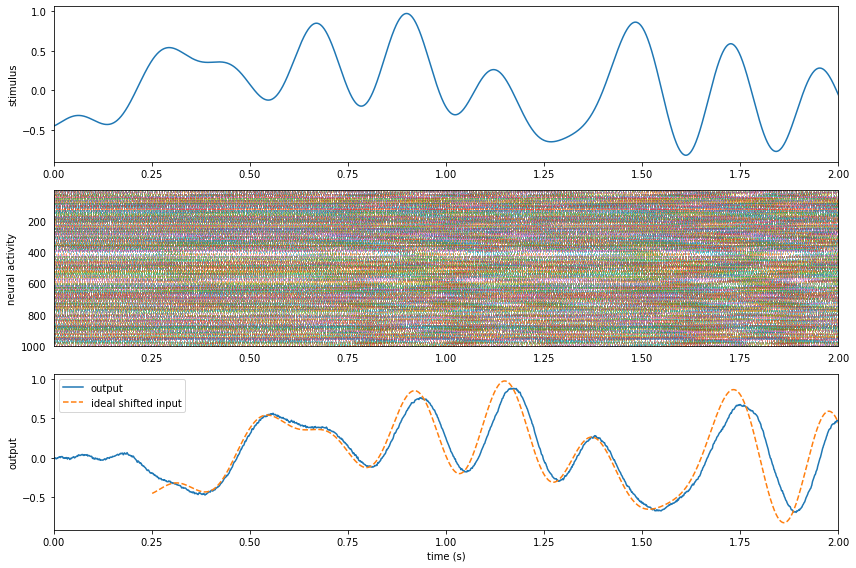

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.xlim(0, 2)
plt.ylabel('stimulus')
plt.subplot(3, 1, 2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_neurons])
plt.ylabel('neural activity')
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_output], label='output')
plt.plot(sim.trange()+ldn.theta, sim.data[p_stim], ls='--', label='ideal shifted input')
plt.legend()
plt.xlim(0, 2)
plt.ylabel('output')
plt.xlabel('time (s)')
plt.tight_layout()



So that's the magic that Nengo is doing behind the scenes.  But with this approach you should be able to take these models and use any other neuron simulator you feel like.  And I hope it at least clarifies what Nengo is doing!